In [34]:
import os
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from pyro.distributions import Normal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
# for CI testing
smoke_test = ('CI' in os.environ)
pyro.enable_validation(True)

%matplotlib inline

In [76]:
N = 100  # size of toy data

def build_linear_dataset(N, p=50, noise_std=0.5):
    X = np.random.rand(N, p)
    # w = 3
    w = 3 * np.ones(p)
    # b = 1
    y = np.dot(X**2, w)  + np.random.normal(0, noise_std, size=N)
    y = y.reshape(N, 1)
    X, y = torch.tensor(X).type(torch.Tensor), torch.tensor(y).type(torch.Tensor)
    data = torch.cat((X, y), 1)
    assert data.shape == (N, p + 1)
    return data

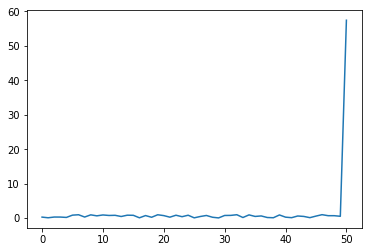

In [77]:
data = build_linear_dataset(N)
data.shape
plt.plot(data.numpy()[2][:])

In [54]:
class  RegressionModel(nn.Module):
    def __init__(self, p):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(p, 1)

    def forward(self, x):
        a = self.linear(x)
        return torch.sigmoid(a)

regression_model = RegressionModel(1)

In [56]:
loss_fn = torch.nn.MSELoss(size_average=False)
optim = torch.optim.Adam(regression_model.parameters(), lr=0.05)
num_iterations = 10000 if not smoke_test else 2

def main():
    data = build_linear_dataset(N)
    x_data = data[:, :-1]
    y_data = data[:, -1]
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = regression_model(x_data).squeeze(-1)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in regression_model.named_parameters():
        print("%s: %.3f" % (name, param.data.numpy()))

if __name__ == '__main__':
    main()

[iteration 0050] loss: 20531.9844
[iteration 0100] loss: 20531.2637
[iteration 0150] loss: 20531.0547
[iteration 0200] loss: 20530.9355
[iteration 0250] loss: 20530.8809
[iteration 0300] loss: 20530.8516
[iteration 0350] loss: 20530.8281
[iteration 0400] loss: 20530.8105
[iteration 0450] loss: 20530.7969
[iteration 0500] loss: 20530.7734
[iteration 0550] loss: 20530.7598
[iteration 0600] loss: 20530.7559
[iteration 0650] loss: 20530.7539
[iteration 0700] loss: 20530.7500
[iteration 0750] loss: 20530.7500
[iteration 0800] loss: 20530.7480
[iteration 0850] loss: 20530.7441
[iteration 0900] loss: 20530.7422
[iteration 0950] loss: 20530.7383
[iteration 1000] loss: 20530.7402
[iteration 1050] loss: 20530.7344
[iteration 1100] loss: 20530.7324
[iteration 1150] loss: 20530.7305
[iteration 1200] loss: 20530.7285
[iteration 1250] loss: 20530.7266
[iteration 1300] loss: 20530.7246
[iteration 1350] loss: 20530.7266
[iteration 1400] loss: 20530.7246
[iteration 1450] loss: 20530.7188
[iteration 150

In [5]:
loc = torch.zeros(1, 1)
scale = torch.ones(1, 1)
# define a unit normal prior
prior = Normal(loc, scale)
# overload the parameters in the regression module with samples from the prior
lifted_module = pyro.random_module("regression_module", regression_model, prior)
# sample a regressor from the prior
sampled_reg_model = lifted_module()


In [7]:
data = build_linear_dataset(N)
data

tensor([[ 0.4003,  2.2615],
        [ 0.4005,  2.1725],
        [ 0.6008,  3.1805],
        ...,
        [ 0.1380,  1.0328],
        [ 0.3884,  3.2729],
        [ 0.0751,  1.3887]])

In [94]:
def  model (data):
    # Create unit normal priors over the parameters# Creat 
    loc, scale = torch.zeros(1, 1), 10 * torch.ones(1, 1)
    bias_loc, bias_scale = torch.zeros(1), 10 * torch.ones(1)
    w_prior = Normal(loc, scale).independent(1)
    b_prior = Normal(bias_loc, bias_scale).independent(1)
    priors = {'linear.weight': w_prior, 'linear.bias': b_prior}
    # lift module parameters to random variables sampled from the priors
    lifted_module = pyro.random_module("module", regression_model, priors)
    # sample a regressor (which also samples w and b)
    lifted_reg_model = lifted_module()
    with pyro.iarange("map", N):
        x_data = data[:, :-1]
        y_data = data[:, -1]
    
        # run the regressor forward conditioned on data
        prediction_mean = lifted_reg_model(x_data).squeeze(-1)
        # condition on the observed data
        pyro.sample("obs", 
                    Normal(prediction_mean, 0.1 * torch.ones(data.size(0))),
                    obs=y_data)


In [95]:
### Define approximate model to perform variational inference with
softplus = torch.nn.Softplus()

def guide(data):
    # define our variational parameters
    w_loc = torch.randn(1, 1)
    # note that we initialize our scales to be pretty narrow
    w_log_sig = torch.tensor(-3.0 * torch.ones(1, 1) + 0.05 * torch.randn(1, 1))
    b_loc = torch.randn(1)
    b_log_sig = torch.tensor(-3.0 * torch.ones(1) + 0.05 * torch.randn(1))
    # register learnable params in the param store
    mw_param = pyro.param("guide_mean_weight", w_loc)
    sw_param = softplus(pyro.param("guide_log_scale_weight", w_log_sig))
    mb_param = pyro.param("guide_mean_bias", b_loc)
    sb_param = softplus(pyro.param("guide_log_scale_bias", b_log_sig))
    # guide distributions for w and b
    w_dist = Normal(mw_param, sw_param).independent(1)
    b_dist = Normal(mb_param, sb_param).independent(1)
    dists = {'linear.weight': w_dist, 'linear.bias': b_dist}
    # overload the parameters in the module with random samples 
    # from the guide distributions
    lifted_module = pyro.random_module("module", regression_model, dists)
    # sample a regressor (which also samples w and b)
    return lifted_module()

In [96]:
optim = Adam({"lr": 0.05})
svi = SVI(model, guide, optim, loss=Trace_ELBO())

In [97]:
def  main():
    pyro.clear_param_store()
    data = build_linear_dataset(N)
    for j in range(num_iterations):
        # calculate the loss and take a gradient step
        loss = svi.step(data)
        if j % 100 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss / float(N)))
            
if __name__ == '__main__':
    main()

[iteration 0001] loss: 628.2576
[iteration 0101] loss: 10.8955
[iteration 0201] loss: 10.9048
[iteration 0301] loss: 10.8735
[iteration 0401] loss: 10.8955
[iteration 0501] loss: 10.8400
[iteration 0601] loss: 10.9076
[iteration 0701] loss: 10.8670
[iteration 0801] loss: 10.8389
[iteration 0901] loss: 10.8403


In [98]:
for name in pyro.get_param_store().get_all_param_names():
    print("[%s]: %.3f" % (name, pyro.param(name).data.numpy()))

[guide_mean_weight]: 3.010
[guide_log_scale_weight]: -4.091
[guide_mean_bias]: 0.987
[guide_log_scale_bias]: -4.425


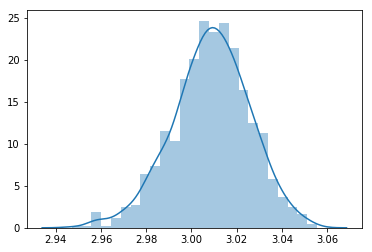

In [100]:
mean = pyro.param('guide_mean_weight').data.numpy()
logsd =pyro.param('guide_log_scale_weight').data.numpy()

sd = np.exp(logsd)
w = np.random.normal(mean[0] , sd[0] , 1000 )

sns.distplot(w)

In [89]:
X  =  np.linspace(6, 7, num=20)
y = 3 * X + 1
X, y = X.reshape((20, 1)), y.reshape((20, 1))
x_data, y_data = torch.tensor(X).type(torch.Tensor), torch.tensor(y).type(torch.Tensor)
loss = nn.MSELoss()
y_preds = torch.zeros(20, 1)
for i in range(20):
    # guide does not require the data
    sampled_reg_model = guide(None)
    # run the regression model and add prediction to total
    y_preds = y_preds + sampled_reg_model(x_data)
# take the average of the predictions
y_preds = y_preds / 20
print ("Loss: ", loss(y_preds, y_data).item())

Loss:  0.26525819301605225
